# Notebook for inferring predictions and comparing model performance

## Import models and functions needed

In [1]:
import json
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model_definitions import KmerCountsModel, FCNNEmbedding, ModularModel
from utils.load_splits import load_splits
from utils.decode_kmer import decode_kmer

## Iterate over data versions, load in both benchmark and neural network models, predict over test set, save losses in dictionary

In [4]:
DATA_VERSION = ["3fC", "5fC", "7fC"]

benchmark_losses = {}
nn_losses = {}

for version in DATA_VERSION:
    X_test, y_test = load_splits(version, requested_splits=["test"])

    X_test_decoded = decode_kmer(X_test)
    y_test_decoded = decode_kmer(y_test)

    model_benchmark = KmerCountsModel.load(f"/faststorage/project/MutationAnalysis/Nimrod/results/models/counts_benchmark/{version}/model.pkl")
    loss_benchmark = model_benchmark.evaluate(X_test_decoded, y_test_decoded)

    benchmark_losses[version] = loss_benchmark

    def onehot_to_indexed_kmers(onehot_data):
        """
        Function to convert one-hot encoding to integer encoding for nn.Embedding()
        by reshaping k-mer to (data_size, kmer_length, mut_outcomes=4) then taking
        argmax
        """

        data_size = onehot_data.size(0)
        kmer_length = onehot_data.size(1) // 4

        reshaped = onehot_data.view(data_size, kmer_length, 4)

        indexed = reshaped.argmax(dim=2)
        return indexed.long()
    
    X_test = onehot_to_indexed_kmers(X_test)

    model_nn = FCNNEmbedding(num_embeddings=4, embedding_dim=32)
    model_nn.load_state_dict(torch.load(f"/faststorage/project/MutationAnalysis/Nimrod/results/models/fc/{version}/model.pth"))

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    test_probs = []
    test_targets = []

    with torch.no_grad():
        for xb, yb in test_loader:
            probs = model_nn.predict_proba(xb)

            test_probs.append(probs.cpu())
            test_targets.append(yb.cpu())

    test_probs = torch.cat(test_probs).numpy()
    test_targets = torch.cat(test_targets).numpy()

    loss_nn = log_loss(test_targets, test_probs)
    nn_losses[version] = loss_nn
    print(f"Test log loss of neural network: {loss_nn}")

Test log loss of neural network: 0.7061033578096845
Test log loss of neural network: 0.7013172564342843
Test log loss of neural network: 0.6999550776535953


Running the evaluation code takes around 14 minutes

In [5]:
print(benchmark_losses)
print(nn_losses)

{'3fC': 0.7057041601791137, '5fC': 0.7010122805378424, '7fC': 0.7513350362888195}
{'3fC': 0.7061033578096845, '5fC': 0.7013172564342843, '7fC': 0.6999550776535953}


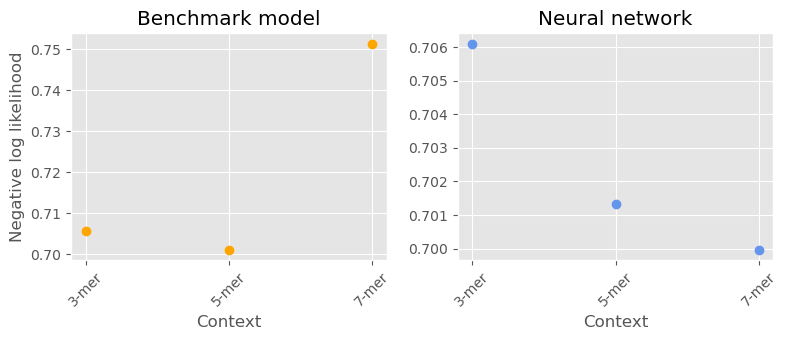

In [6]:
results_df = pd.DataFrame({
    "Benchmark model": benchmark_losses,
    "Neural network": nn_losses
})

plt.style.use("ggplot")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

# Plot benchmark values
axes[0].plot(["3-mer", "5-mer", "7-mer"], results_df["Benchmark model"], 'o', color='orange')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title("Benchmark model")
axes[0].set_xlabel("Context")
axes[0].set_ylabel("Negative log likelihood")

# Plot neural network values
axes[1].plot(["3-mer", "5-mer", "7-mer"], results_df["Neural network"], 'o', color='cornflowerblue')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_title("Neural network")
axes[1].set_xlabel("Context")

# Improve layout
plt.tight_layout()
plt.show()

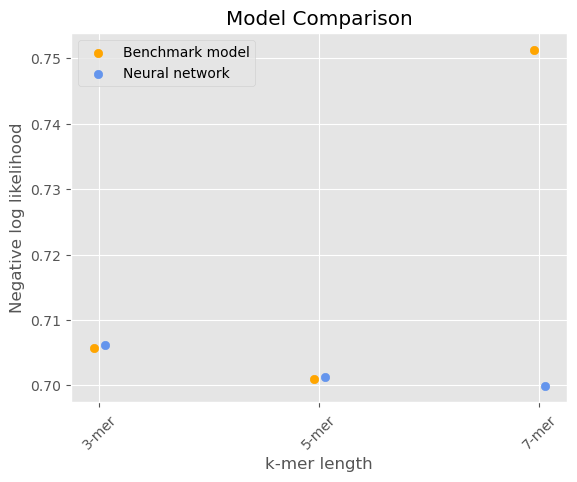

In [7]:
# X-axis labels
x_labels = ["3-mer", "5-mer", "7-mer"]
x = np.arange(len(x_labels))  # Positions for the x-axis

# Create plot
fig, ax = plt.subplots()

# Plot points
jitter = 0.025
ax.scatter(x - jitter, results_df["Benchmark model"], label="Benchmark model", color='orange')
ax.scatter(x + jitter, results_df["Neural network"], label="Neural network", color='cornflowerblue')

# Customize plot
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.tick_params(axis="x", rotation=45)
ax.set_title("Model Comparison")
ax.set_xlabel("k-mer length")
ax.set_ylabel("Negative log likelihood")
ax.legend()

plt.show()

## Compare NNs using different features and different bin sizes

In [7]:
with open("/faststorage/project/MutationAnalysis/Nimrod/results/log_losses_combined_models_C.json") as f:
    all_losses = json.load(f)

In [8]:
rows = []

for feature_set, data_versions in all_losses.items():
    for data_version, bin_sizes in data_versions.items():
        for bin_size, loss in bin_sizes.items():
            rows.append({
                "feature_set": feature_set,
                "data_version": data_version,
                "bin_size": bin_size,
                "loss": loss
            })

In [9]:
losses_df = pd.DataFrame(rows)

In [11]:
losses_df["feature_set"].unique()

array(['avgmut', 'avgmut_binnorm', 'avgmut_binid_binnorm', 'binid',
       'binnorm'], dtype=object)

In [10]:
losses_df["data_version"].unique()

array(['3fA', '3fC', '5fA', '5fC', '7fA', '7fC', '9fA', '9fC', '11fA',
       '11fC', '13fA', '13fC', '15fA', '15fC'], dtype=object)

In [11]:
losses_df = losses_df[losses_df["data_version"].str.endswith("A")]

In [12]:
losses_df.head()

,feature_set,data_version,bin_size,loss
0,avgmut,3fA,100kb,0.447597
1,avgmut,3fA,500kb,0.492481
2,avgmut,3fA,1mb,0.499202
6,avgmut,5fA,100kb,0.443248
7,avgmut,5fA,500kb,0.486339


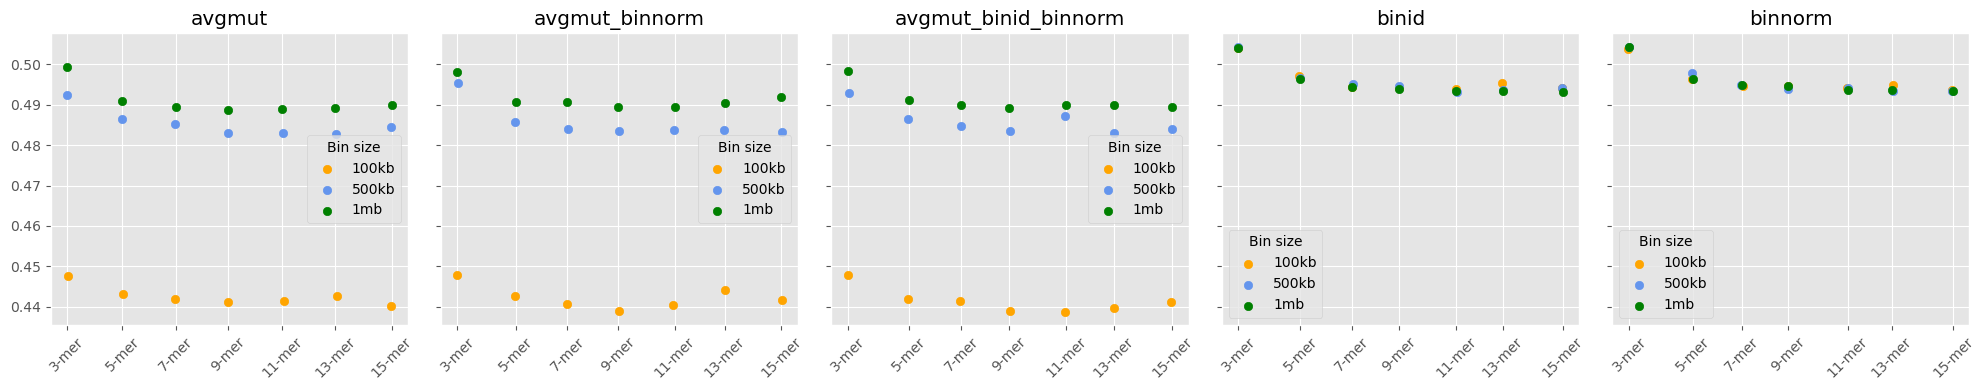

In [13]:
plt.style.use("ggplot")

x_labels = ["3-mer", "5-mer", "7-mer", "9-mer", "11-mer", "13-mer", "15-mer"]
x_vals = np.arange(len(x_labels)) # Convert labels to integers

binsize_order = ["100kb", "500kb", "1mb"]
losses_df["bin_size"] = pd.Categorical(losses_df["bin_size"], categories=binsize_order, ordered=True)

# Obtain number of different feature sets to group by and facet later
feature_sets = losses_df["feature_set"].unique()
n_feature_sets = len(feature_sets)

colors = {"100kb": "orange", "500kb": "cornflowerblue", "1mb": "green"}
jitter = 0.025

fig, axes = plt.subplots(nrows=1, ncols=n_feature_sets, figsize=(4 * n_feature_sets, 4), sharey=True)

for ax, feature_set in zip(axes, feature_sets):
    sub_df = losses_df[losses_df["feature_set"] == feature_set]

    for bin_size, group in sub_df.groupby("bin_size", observed=True):
        x_vals = x_vals + np.random.uniform(-jitter, jitter, size=len(x_vals))
        ax.scatter(
            x=x_vals,
            y=group["loss"],
            label=bin_size,
            color=colors[bin_size]
        )
    
    ax.set_title(feature_set)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x_labels)
    ax.tick_params(axis="x", rotation=45)
    ax.legend(title="Bin size")

plt.tight_layout()
plt.show()

In [ ]:
# Out of the figures above, I need to put "binid" and "binnorm" side by side
# "avgmut" vs "binnorm" vs both

## Bin ID vs bin normalized

/tmp/ipykernel_1940917/607182684.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["bin_size"] = pd.Categorical(temp_df["bin_size"], categories=binsize_order, ordered=True)


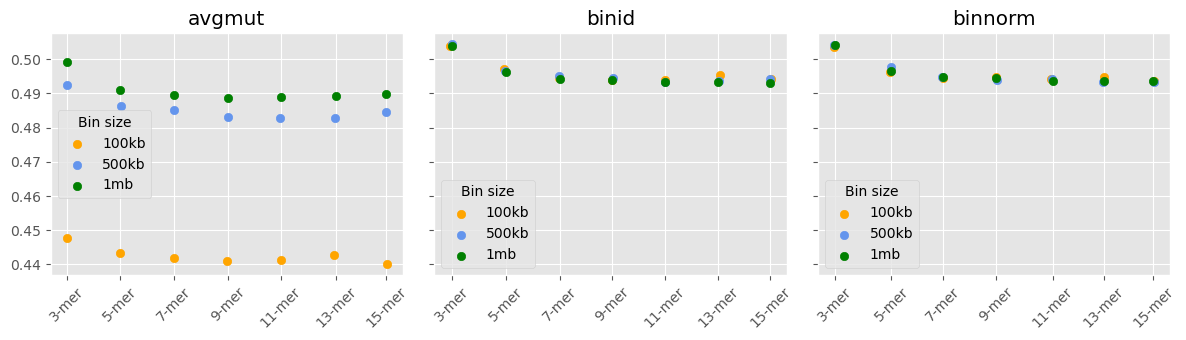

In [14]:
temp_df = losses_df[(losses_df["feature_set"] == "binid") | (losses_df["feature_set"] == "binnorm") | (losses_df["feature_set"] == "avgmut")]

plt.style.use("ggplot")

x_labels = ["3-mer", "5-mer", "7-mer", "9-mer", "11-mer", "13-mer", "15-mer"]
x_vals = np.arange(len(x_labels)) # Convert labels to integers

binsize_order = ["100kb", "500kb", "1mb"]
temp_df["bin_size"] = pd.Categorical(temp_df["bin_size"], categories=binsize_order, ordered=True)

# Obtain number of different feature sets to group by and facet later
feature_sets = temp_df["feature_set"].unique()
n_feature_sets = len(feature_sets)

colors = {"100kb": "orange", "500kb": "cornflowerblue", "1mb": "green"}
jitter = 0.025

fig, axes = plt.subplots(nrows=1, ncols=n_feature_sets, figsize=(4 * n_feature_sets, 3.5), sharey=True)

for ax, feature_set in zip(axes, feature_sets):
    sub_df = temp_df[temp_df["feature_set"] == feature_set]

    for bin_size, group in sub_df.groupby("bin_size", observed=True):
        x_vals = x_vals + np.random.uniform(-jitter, jitter, size=len(x_vals))
        ax.scatter(
            x=x_vals,
            y=group["loss"],
            label=bin_size,
            color=colors[bin_size]
        )
    
    ax.set_title(feature_set)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x_labels)
    ax.tick_params(axis="x", rotation=45)
    ax.legend(title="Bin size")

plt.tight_layout()
plt.show()

## Avg mut vs avg mut + bin norm vs all three

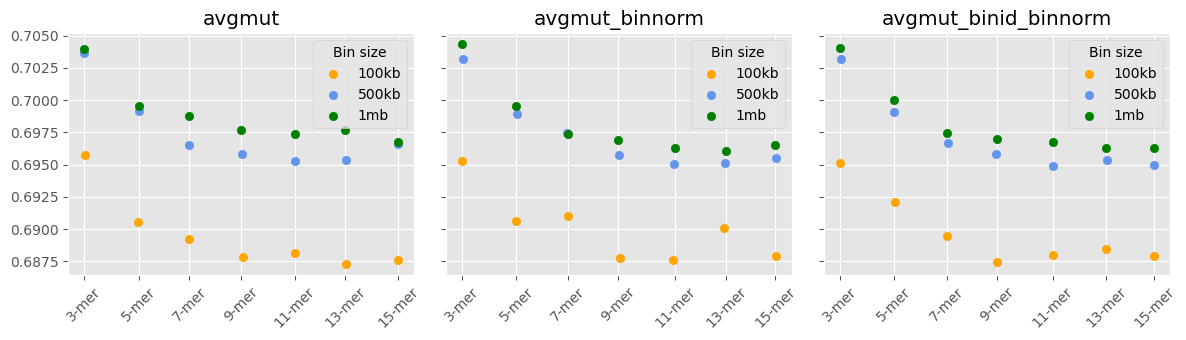

In [16]:
feature_set_order = ["avgmut", "avgmut_binnorm", "avgmut_binid_binnorm"]

# Filter DataFrame and set feature_set as a categorical variable to preserve order
temp_df = losses_df[losses_df["feature_set"].isin(feature_set_order)].copy()
temp_df["feature_set"] = pd.Categorical(temp_df["feature_set"], categories=feature_set_order, ordered=True)

# temp_df = losses_df[(losses_df["feature_set"] == "avgmut") | (losses_df["feature_set"] == "binnorm") | (losses_df["feature_set"] == "avgmut_binnorm")]

plt.style.use("ggplot")

x_labels = ["3-mer", "5-mer", "7-mer", "9-mer", "11-mer", "13-mer", "15-mer"]
x_vals = np.arange(len(x_labels)) # Convert labels to integers

binsize_order = ["100kb", "500kb", "1mb"]
temp_df["bin_size"] = pd.Categorical(temp_df["bin_size"], categories=binsize_order, ordered=True)

# Obtain number of different feature sets to group by and facet later
feature_sets = temp_df["feature_set"].unique()
n_feature_sets = len(feature_sets)

colors = {"100kb": "orange", "500kb": "cornflowerblue", "1mb": "green"}
jitter = 0.025

fig, axes = plt.subplots(nrows=1, ncols=n_feature_sets, figsize=(4 * n_feature_sets, 3.5), sharey=True)

for ax, feature_set in zip(axes, feature_set_order):
    sub_df = temp_df[temp_df["feature_set"] == feature_set]

    for bin_size, group in sub_df.groupby("bin_size", observed=True):
        x_vals = x_vals + np.random.uniform(-jitter, jitter, size=len(x_vals))
        ax.scatter(
            x=x_vals,
            y=group["loss"],
            label=bin_size,
            color=colors[bin_size]
        )
    
    ax.set_title(feature_set)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x_labels)
    ax.tick_params(axis="x", rotation=45)
    ax.legend(title="Bin size")

plt.tight_layout()
plt.show()

## Create "mutation outcomes per k-mer type" figure
### Generate list of each possible k-mer context
Only suitable for 3-mers due to number of possible k-mers with higher length

In [ ]:
DATA_VERSION = "3fA"

version_map = {
        "3fA": "3mer_full_A",
        "3fC": "3mer_full_C",
        "3sA": "3mer_subset_A",
        "3sC": "3mer_subset_C",
        "5fA": "5mer_full_A",
        "5fC": "5mer_full_C",
        "7fA": "7mer_full_A",
        "7fC": "7mer_full_C",
        "9fA": "9mer_full_A",
        "9fC": "9mer_full_C",
        "11fA": "11mer_full_A",
        "11fC": "11mer_full_C",
        "13fA": "13mer_full_A",
        "13fC": "13mer_full_C",
        "15fA": "15mer_full_A",
        "15fC": "15mer_full_C",
        "15sA": "15mer_subset_A",
        "15sC": "15mer_subset_C",
        "experiment_full": "experiment_full",
        "experiment_subset": "experiment_subset"
    }

df = pd.read_csv(f"/faststorage/project/MutationAnalysis/Nimrod/data/processed/{version_map[DATA_VERSION]}.tsv", sep="\t")

distinct_contexts = df["context"].drop_duplicates().sort_values(ignore_index=True)
distinct_contexts = list(distinct_contexts)

### Use model.predict_proba() to obtain probability distribution of mutation outcomes for each k-mer type

In [ ]:
model = FCNNEmbedding(num_embeddings=4, embedding_dim=32)
model.load_state_dict(torch.load(f"/faststorage/project/MutationAnalysis/Nimrod/results/models/fc/{DATA_VERSION}/model.pth"))

probs = []

def one_hot_encode_3mer(context):
    nucleotides = ['A', 'C', 'G', 'T']
    nuc_to_int = {nuc: i for i, nuc in enumerate(nucleotides)} # Encode nucl to int
    onehot_array = np.concatenate([np.eye(4)[nuc_to_int[nuc]] for nuc in context])
    return torch.as_tensor(onehot_array, dtype=torch.float32)


for context in distinct_contexts:
    context_onehot = one_hot_encode_3mer(context)
    model.eval()
    with torch.no_grad():
        prob_distr = model.predict_proba(context_onehot).detach().numpy()
        probs.append(prob_distr)

nucleotides = ['A', 'C', 'G', 'T']
probs = pd.DataFrame(probs, columns=nucleotides, index=distinct_contexts)
probs

,A,C,G,T
AAAAA,0.918009,0.019695,0.049612,0.012684
AAAAC,0.932160,0.019248,0.034156,0.014435
AAAAG,0.919127,0.024437,0.042907,0.013529
AAAAT,0.918691,0.024032,0.034005,0.023273
AAACA,0.886547,0.017345,0.076713,0.019395
...,...,...,...,...
TTAGT,0.873586,0.031941,0.072503,0.021970
TTATA,0.790410,0.016034,0.154482,0.039075
TTATC,0.817766,0.020132,0.115807,0.046295
TTATG,0.816581,0.020348,0.117160,0.045911


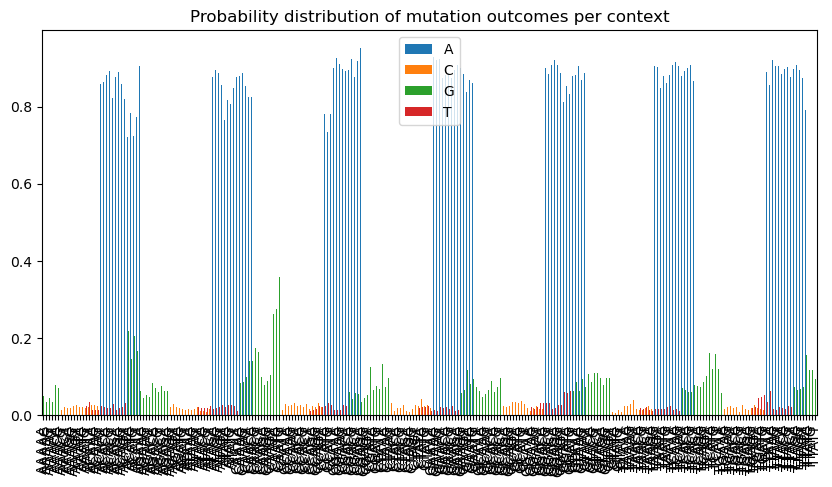

In [7]:
probs.plot(kind="bar", figsize=(10, 5))
plt.title("Probability distribution of mutation outcomes per context")
plt.show()